# Streaming

## Review

In module 2, we built a deeper understanding of both state and memory.

We built up a Chatbot with external memory (Postgres Checkpointer) that can sustain long-running conversations.

## Goals

This module we dive into `human-in-the-loop`, which builds on memory and allows users to interact with agents.

To set the stage for `human-in-the-loop`, we're going to first deep dive into streaming.


## Dependencies

In [4]:
from typing import TypedDict
from IPython.display import display, Image
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START,END, MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver


## Streaming

LangGraph is built with first class support for streaming.

Let's setup our Chatbot from MModule 2, and show how this can be used with streaming

In [2]:
llm = ChatOllama(
    model="llama3.1",
    base_url="http://localhost:11434",
    temperaature=0.8,
    max_tokens=1000,
)

In [3]:
class State(MessagesState):
    summary:str

In [5]:
def call_model(state: State):

    summary = state.get("summary","")

    if summary:

        system_message = f"Summary of conversation earlier: {summary}"

        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = llm.invoke(messages)
    return {
        "messages":response
    }

def summarize_conversattion(state: State):

    summary = state.get("summary","")

    if summary:

        system_message = f"This is the current conversation summary: {summary}. \n Extend the summary by taking into account the new messages above:"

    else:
        system_message = "Create a conversation summary given the messages above:"

    messages = state["messages"] + [HumanMessage(content=system_message)]
    response = llm.invoke(messages)

    # Delete the messages
    recent_messages = [RemoveMessage(id=m.id) for m in state['messages'][-2:]]

    return {
        "summary": response.content, messages: recent_messages
    }

def should_continue(state: State):

    messages = state['messages']
    if len(messages) > 6:
        return 'summarize_conversation'
    return END

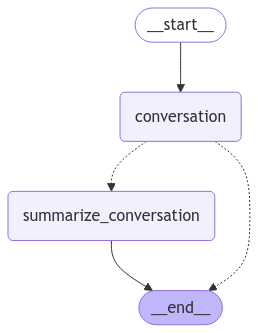

In [6]:
builder = StateGraph(State)
builder.add_node("conversation", call_model)
builder.add_node("summarize_conversation",summarize_conversattion)

# Add edges
builder.add_edge(START, "conversation"),
builder.add_conditional_edges("conversation", should_continue)
builder.add_edge("summarize_conversation",END)

# Compile
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Streaming Full State

Now let's talk about ways to stream our graph state.

`.stream` and `.astream` are sync and async methods for streaming back results.

LangGraph supports a few different streaming modes for graph state:

- `values`: This streams the full state of the graph after each node is called.
- `updates`: This streams updates of the state of the graph after each node is called.

<center><img src="../../../assets/streaming.png" width=900 alt="streaming"></img></center>

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after each step of the graph.

Each `chunk` is a dict with `node_name` has the key and the updated state s the value.

In [7]:
# Create a thread
config = {"configurable": {"thread_id":"1"}}

In [9]:
#Start the conversation
for chunk in graph.stream({"messages": [HumanMessage(content="Hello, my name is Guilherme Toso!")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Olá Guilherme! (That\'s "hello" in Portuguese!) It\'s nice to meet you. I\'m here to chat and help with any questions or topics you\'d like to discuss. Where are you from? Are you originally from Brazil, where Portuguese is the official language?', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-01-07T17:31:32.4014627Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6022861500, 'load_duration': 4413134700, 'prompt_eval_count': 21, 'prompt_eval_duration': 300000000, 'eval_count': 59, 'eval_duration': 1307000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-b6053848-d1f5-4d51-87c4-e67d9f7106d2-0', usage_metadata={'input_tokens': 21, 'output_tokens': 59, 'total_tokens': 80})}}


Now let's print the state updates

In [10]:
for chunk in graph.stream({"messages":[HumanMessage("Hello, I'm Guilherme!")]}, config, stream_mode="updates"):
    chunk['conversation']['messages'].pretty_print()

================================== Ai Message ==================================

Nice to meet you, Guilherme! Since we just started our conversation, feel free to share a bit about yourself: what do you like to talk about or discuss? Are you interested in learning something new, or perhaps sharing your hobbies and interests with me?


Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [12]:
# Define a new thread
config = {"configurable":{"thread_id":"2"}}

In [13]:
# Start conversation again
input_message = HumanMessage(content="Hello, My name is Guilherme Toso!")
for event in graph.stream({"messages":[input_message]}, config, stream_mode="values"):
    for m in event["messages"]:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

Hello, My name is Guilherme Toso!
---------------------------------------------------------------------------
================================ Human Message =================================

Hello, My name is Guilherme Toso!
================================== Ai Message ==================================

Olá Guilherme! (That's "hello" in Portuguese!) Nice to meet you! I don't have any information about a specific person named Guilherme Toso, so this is the start of our conversation. How can I assist or chat with you today? Are there any topics on your mind that you'd like to discuss?
---------------------------------------------------------------------------


## Streaming Tokens

But, we often want to stream more that state.

In particular, with LLM calls it is common to stream tthe tokens as they are generated.

We can do this using the `.astream_events` method, which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

- `event`: This is the type of event that is being emitted.
- `name`: This is the name of the event.
- `data`: This is the data associated with the event.
- `metadatta`: Which contains `langgraph_node`, the node emitting the event.

Let's have a look.

In [14]:
config = {"configurable":{"thread_id":"3"}}
input_message = HumanMessage(content="Tell me about quantum physics!")
async for event in graph.astream_events({"messages":[input_message]}, config, version="v2"):
    print(f"Node: {event["metadata"].get("langgraph_node")}. Type: {event['event']}. Name: {event['name']}")

Node: None. Type: on_chain_start. Name: LangGraph
Node: __start__. Type: on_chain_start. Name: __start__
Node: __start__. Type: on_chain_start. Name: _write
Node: __start__. Type: on_chain_end. Name: _write
Node: __start__. Type: on_chain_start. Name: _write
Node: __start__. Type: on_chain_end. Name: _write
Node: __start__. Type: on_chain_stream. Name: __start__
Node: __start__. Type: on_chain_end. Name: __start__
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOllama
Node: conversation. Type: on_chat_model_stream. Name: ChatOllama
Node: conversation. Type: on_chat_model_stream. Name: ChatOllama
Node: conversation. Type: on_chat_model_stream. Name: ChatOllama
Node: conversation. Type: on_chat_model_stream. Name: ChatOllama
Node: conversation. Type: on_chat_model_stream. Name: ChatOllama
Node: conversation. Type: on_chat_model_stream. Name: ChatOllama
Node: conversation. Type: on_chat_model_stream. Name: ChatOllama
No

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event["metadata"]["langgraph_node"]` to select the node to stream from.

And we can use `event["data"]` to get the actual data for each event, which in this case is an `AIMessageChunk`

In [18]:
node_to_stream="conversation"
config = {"configurable":{"thread_id":"222"}}
input_message = HumanMessage(content="Tell me something about the third law of physics by Newton!")
async for event in graph.astream_events({"messages":[input_message]}, config, version="v2"):
    if event['event'] == "on_chat_model_stream" and event['metadata'].get("langgraph_node") == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='You', additional_kwargs={}, response_metadata={}, id='run-3830a524-a989-49e7-9036-aa92227cf15f')}
{'chunk': AIMessageChunk(content="'re", additional_kwargs={}, response_metadata={}, id='run-3830a524-a989-49e7-9036-aa92227cf15f')}
{'chunk': AIMessageChunk(content=' referring', additional_kwargs={}, response_metadata={}, id='run-3830a524-a989-49e7-9036-aa92227cf15f')}
{'chunk': AIMessageChunk(content=' to', additional_kwargs={}, response_metadata={}, id='run-3830a524-a989-49e7-9036-aa92227cf15f')}
{'chunk': AIMessageChunk(content=' one', additional_kwargs={}, response_metadata={}, id='run-3830a524-a989-49e7-9036-aa92227cf15f')}
{'chunk': AIMessageChunk(content=' of', additional_kwargs={}, response_metadata={}, id='run-3830a524-a989-49e7-9036-aa92227cf15f')}
{'chunk': AIMessageChunk(content=' the', additional_kwargs={}, response_metadata={}, id='run-3830a524-a989-49e7-9036-aa92227cf15f')}
{'chunk': AIMessageChunk(content=' most', additional_kwargs={}, res

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [20]:
config = {"configurable":{"thread_id":"222"}}
input_message = HumanMessage(content="Tell me something about the third law of physics by Newton!")
async for event in graph.astream_events({"messages":[input_message]}, config, version="v2"):
    if event['event'] == "on_chat_model_start" and event['metadata'].get("langgraph_node") == node_to_stream:
        print("AI:", end=" ")
    if event['event'] == "on_chat_model_stream" and event['metadata'].get("langgraph_node") == node_to_stream:
        data = event['data']
        print(data["chunk"].content, end="")

AI: Newton's Third Law states:

**"To every action, there is an equal and opposite reaction."**

This means that when one object exerts a force on another object, the second object will always exert an equal and opposite force on the first object. The forces are of equal magnitude but in opposite directions.

For instance:

* When you throw a ball upwards, the ball exerts an upward force on your hand, and your hand exerts an equal downward force on the ball.
* When a boat pushes against the water to move forward, the water pushes back against the boat with equal force.
* When a rocket engine fires, it expels hot gases in one direction, and the rocket moves in the opposite direction with equal speed.

This law is essential for understanding many physical phenomena, from the motion of objects on Earth to the behavior of celestial bodies in space.

## Streaming with LangGraph API

Our Chatbot is deployed locally to Studio and the LangGraph API serves as the backend for Studio.

We can interact with the API via the LangGraph SDK.

Let's get th URL for the local deployment from Stusdio: ` http://127.0.0.1:2024`

In [24]:
from langgraph_sdk import get_client

URL="http://127.0.0.1:2024"
client = get_client(url=URL)

# Assistants
assistants = await client.assistants.search()
assistants

[{'assistant_id': '166c0d22-706c-5a5b-9027-ea37f7308a85',
  'graph_id': 'react',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'react',
  'created_at': '2024-12-29T16:26:28.065150+00:00',
  'updated_at': '2024-12-29T16:26:28.065150+00:00',
  'version': 1},
 {'assistant_id': '228f9934-0cdd-5383-92c8-ee8422522cc2',
  'graph_id': 'router',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'router',
  'created_at': '2024-12-29T16:26:27.689297+00:00',
  'updated_at': '2024-12-29T16:26:27.689297+00:00',
  'version': 1},
 {'assistant_id': '608f7b9c-04e5-5cf2-a3f7-ba75a3719808',
  'graph_id': 'chain',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'chain',
  'created_at': '2024-12-29T16:26:27.316657+00:00',
  'updated_at': '2024-12-29T16:26:27.316657+00:00',
  'version': 1},
 {'assistant_id': '5e0f6b46-d00f-5af4-87dc-ea2105ff526d',
  'graph_id': 'simple',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'simple',
  'create

Let's stream `values` like before.

In [25]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="react", input={
    "messages": [input_message]
}, stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '1efcd283-d89d-6b47-b20c-c1f0fa615525', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'additional_kwargs': {}, 'response_metadata': {}, 'example': False}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '79dd21f5-65c2-426a-8465-0eba8ea2563b', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'additional_kwargs': {}, 'response_metadata': {}, 'example': False}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '79dd21f5-65c2-426a-8465-0eba8ea2563b', 'example': False}, {'content': '', 'additional_kwargs': {}, 'response_metadata': {'model': 'llama3.1-tool', 'created_at': '2025-01-07T18:50:24.4321953Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3187571300, 'load_duration': 1901753100, 'prompt_eval_count': 375, 'prompt_eval_duration': 256000000, 'eval_count': 22, 'eval_du

The streamed objects have:

- `event`: Type
- `data`: State

In [26]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3.")
async for event in client.runs.stream(thread["thread_id"], assistant_id="react", input={"messages":[input_message]}, stream_mode="values"):
    messages = event.data.get("messages",None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print("---"*25)

---------------------------------------------------------------------------
content='Multiply 2 and 3.' additional_kwargs={'additional_kwargs': {'additional_kwargs': {}, 'response_metadata': {}, 'example': False}, 'response_metadata': {}, 'example': False} response_metadata={} id='11893e5f-f1bc-4fe4-869b-ef874bf38eb9'
---------------------------------------------------------------------------
content='' additional_kwargs={'additional_kwargs': {}, 'response_metadata': {'model': 'llama3.1-tool', 'created_at': '2025-01-07T18:55:04.6796013Z', 'done': True, 'done_reason': 'stop', 'total_duration': 753573600, 'load_duration': 14106800, 'prompt_eval_count': 376, 'prompt_eval_duration': 188000000, 'eval_count': 22, 'eval_duration': 549000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, 'example': False, 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 376, 'output_tokens': 22, 'total_tokens': 398}} response_metadata={} id='run-7c5346d0-8647

There are some new streaming mode that are only supported via the API.

For example, we can use `messages` mod to better handle the above case!

This mode currently assumes that you have a `messages` key in your graph that is a list of messages.

All events emitted have two attributes:

- `event`: This is the name of the event.
- `data`: This is data associated with the event.

In [27]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3.")
async for event in client.runs.stream(thread["thread_id"], assistant_id="react", input={"messages":[input_message]}, stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/metadata
messages/complete
messages/metadata
messages/partial


We can  see a few events:

- `metadata`: metadata about the run.
- `messages/complete`: fully formed message.
- `messages/partial`: LLM Tokens

Now, let's show how stream these messages.

The nice thing is that we can get token-wise streaming of partial messages!

We'll define a helper function for better formtting of the tool calls in messages.

In [28]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3.")

def format_tool_calls(tool_calls):
    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(f"Tool Call Id: {call['id']}, Funcion: {call['name']}, Arguments: {call['args']}")
        return "\n".join(formatted_calls)
    return "No tools called"

async for event in client.runs.stream(thread['thread_id'], assistant_id="react", input={"messages":[input_message]}, stream_mode="messages"):
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data["run_id"]}")
        print("--"*25)

    elif event.event == "messages/partial":
        for data_item in event.data:
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item["content"]}")
            else:
                tool_calls = data_item.get("tool_calls",[])
                invalid_tool_calls = data_item.get("invalid_tool_calls",[])
                content = data_item.get("content","")
                response_metadata = data_item.get("response_metadata",{})

                if content:
                    print(f"AI: {content}")
                
                if tool_calls:
                    print("Tool Calls")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish reason","N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
        print("-"*50)

Metadata: Run ID - 1efcd2b8-22f0-60e8-aad2-85a5393284ce
--------------------------------------------------
Tool Calls
Tool Call Id: 30f26889-9e6b-4df2-9440-385aa7fc1c52, Funcion: multiply, Arguments: {'a': 2, 'b': 3}
--------------------------------------------------
Tool Calls
Tool Call Id: 30f26889-9e6b-4df2-9440-385aa7fc1c52, Funcion: multiply, Arguments: {'a': 2, 'b': 3}
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: The result of multiplying 2 and 3 is 6.
Response Metadata: Finish Reason - N/A
--------------------------------------------------
